In [1]:
# This example demonstrates a simple OCR model built with the Functional API
# Apart from combining CNN and RNN, it is also illustrates how you can instantitae a new layer and use it 
   # as an "Endpoint layer" for implementing CTC loss.

    
#  For a detailed guide to layer subclassing, please check out this
# https://keras.io/guides/making_new_layers_and_models_via_subclassing/


### Setup

In [2]:
import os

import zipfile # To Unzip downloaded file
import shutil  # To move downloaded data
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


### Load the data: Captcha Images

In [3]:
# !curl -LO https://github.com/AakashKumarNain/CaptchaCracker/raw/master/captcha_images_v2.zip

In [4]:
# Move and Unzip captcha_imazes_v2.zip
#  shutil.move("captcha_images_v2.zip", "../data_sets/")

In [5]:
# Unzip 
#   with zipfile.ZipFile('../data_sets/captcha_images_v2.zip', 'r') as z_fp:  
#       z_fp.extractall('../data_sets/')

In [6]:
files = os.listdir('../data_sets/captcha_images_v2/')
print(len(files))

1040


In [7]:
# The data set contains 1040 captcha files as png images.
# The label for each sample is a string, the name of the file (munus the file extension )
# We will map each character in the string to an integer for training the model
# Similary, we will need to map the  predictions of the model back to strings.

# For this purpose we will maintain two dictionaries, mapping characters to integers and integers to characters

In [8]:
# Path to the data directory
data_dir = Path("../data_sets/captcha_images_v2/")

# List of all the images
images = images = sorted(list(map(str, list(data_dir.glob("*.png")))))
images[:5]

['..\\data_sets\\captcha_images_v2\\226md.png',
 '..\\data_sets\\captcha_images_v2\\22d5n.png',
 '..\\data_sets\\captcha_images_v2\\2356g.png',
 '..\\data_sets\\captcha_images_v2\\23mdg.png',
 '..\\data_sets\\captcha_images_v2\\23n88.png']

In [9]:
print(os.path.sep)
'..\\data_sets\\captcha_images_v2\\226md.png'.split(os.path.sep)

\


['..', 'data_sets', 'captcha_images_v2', '226md.png']

In [10]:
'..\\data_sets\\captcha_images_v2\\226md.png'.split("\\")[-1].split('.png')[0]

'226md'

In [11]:
# From the above we will extractlabels like 226md in the first
labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]
labels[:5]

['226md', '22d5n', '2356g', '23mdg', '23n88']

In [12]:
# Find Total Unique characters in Captchas
characters = set(char for label in labels for char in label)

In [13]:
",".join(list(characters))

'w,8,4,g,p,x,6,d,7,m,2,f,c,b,n,e,y,3,5'

In [14]:
# Batch size for training and validation
batch_size = 16

# Desired image dimensions
img_width = 200
img_height = 50

# Factor by which the image is going to be downsampled
# by the convolutional blocks. We will be using two
# Convolution blocks and each block will have
# a pooling layer which downsample the features by a factor of 2.
# Hense total downsampling factor would be 4

downsample_factor = 4

# Maximum length of any captcha in the dataset
max_length = max([len(label) for label in labels])

# Minimum length of any captcha in the dataset
min_length = min([len(label) for label in labels])

In [15]:
print("Number of Images found in the folder ", len(images))
print("Number of labels found ", len(labels))
print("Number of Unique characters: ", len(characters))
print("Characters present: ", characters)
print("Maximum length of any cpatcha in images ", max_length)
print("Minimum length of any captcha in images", min_length)

Number of Images found in the folder  1040
Number of labels found  1040
Number of Unique characters:  19
Characters present:  {'w', '8', '4', 'g', 'p', 'x', '6', 'd', '7', 'm', '2', 'f', 'c', 'b', 'n', 'e', 'y', '3', '5'}
Maximum length of any cpatcha in images  5
Minimum length of any captcha in images 5


### Preprocessing

In [16]:
# Mapping Characters to integers

char_to_num = layers.experimental.preprocessing.StringLookup(vocabulary = list(characters), num_oov_indices = 0, 
                                                            mask_token = None)

In [17]:
## Mapping integers back to Original characters
num_to_char = layers.experimental.preprocessing.StringLookup(
                vocabulary = char_to_num.get_vocabulary(), mask_token = None, invert = True)

In [18]:
### To Split the data

def split_data(images, labels, train_size=0.9, shuffle=True):
    # 1. Get the total size of the dataset
    size = len(images)
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Get the size of training samples
    train_samples = int(size * train_size)
    # 4. Split data into training and validation sets
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid

### Splitting data into training and validation sets

In [19]:
x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))


In [20]:
def encode_single_sample(img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    # 6. Map the characters in label to numbers
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. Return a dict as our model is expecting two inputs
    return {"image": img, "label": label}

## Create Dataset objects

In [21]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

## Visualize the data

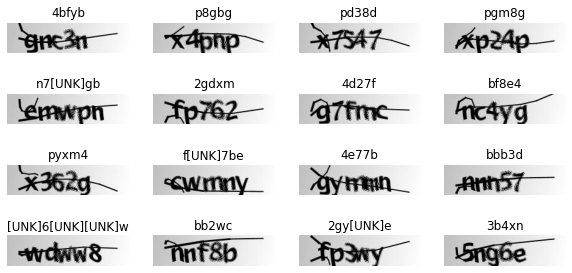

In [22]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

In [23]:
batch.keys()

dict_keys(['image', 'label'])

In [24]:
labels[0]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([ 3, 14, 12, 17, 14], dtype=int64)>

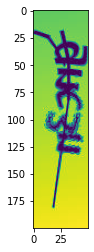

In [25]:
plt.imshow(images[0])

In [26]:
# Path to the data directory
#data_dir = Path("./captcha_images_v2/")

# Get list of all the images
images = sorted(list(map(str, list(data_dir.glob("*.png")))))
labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]
characters = set(char for label in labels for char in label)

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

# Batch size for training and validation
batch_size = 16

# Desired image dimensions
img_width = 200
img_height = 50

# Factor by which the image is going to be downsampled
# by the convolutional blocks. We will be using two
# convolution blocks and each block will have
# a pooling layer which downsample the features by a factor of 2.
# Hence total downsampling factor would be 4.
downsample_factor = 4

# Maximum length of any captcha in the dataset
max_length = max([len(label) for label in labels])

Number of images found:  1040
Number of labels found:  1040
Number of unique characters:  19
Characters present:  {'w', '8', '4', 'g', 'p', 'x', '6', 'd', '7', 'm', '2', 'f', 'c', 'b', 'n', 'e', 'y', '3', '5'}


In [27]:
# Mapping characters to integers
char_to_num = layers.experimental.preprocessing.StringLookup(
    vocabulary=list(characters), num_oov_indices=0, mask_token=None
)

# Mapping integers back to original characters
num_to_char = layers.experimental.preprocessing.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)


def split_data(images, labels, train_size=0.9, shuffle=True):
    # 1. Get the total size of the dataset
    size = len(images)
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Get the size of training samples
    train_samples = int(size * train_size)
    # 4. Split data into training and validation sets
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid


# Splitting data into training and validation sets
x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))


def encode_single_sample(img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    # 6. Map the characters in label to numbers
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. Return a dict as our model is expecting two inputs
    return {"image": img, "label": label}

In [28]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

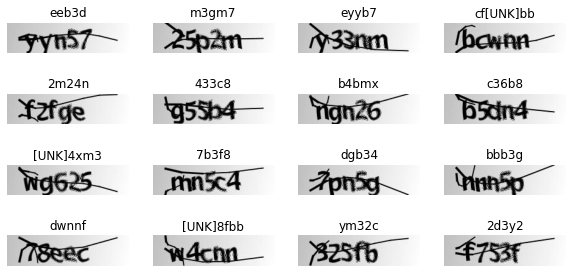

In [31]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

##### Our image and labels are mis matched so training is meaning less i will find reason later